In [138]:
import create_data
import kmeans
import voltage
import os
import importlib
import time
import bpf
import numpy as np


from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [69]:
importlib.reload(create_data)
importlib.reload(kmeans)
importlib.reload(voltage)
importlib.reload(bpf)

<module 'bpf' from 'C:\\Users\\avigh\\Documents\\python\\VoltageDimentionalReduction\\code\\bpf.py'>

In [70]:
print("Loading Data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int64)

# data = create_data.Data(np.array(X))

Loading Data...


In [71]:
# MNIST Pre-processing

subDivision = {}
summation = {}
count = {}

print("Sorting and averaging...")

for xi, yi in zip(X, y):
    if yi in summation:
        subDivision[yi].append(np.array(xi))
        summation[yi] += np.array(xi)
        count[yi] += 1
    else:
        subDivision[yi] = [np.array(xi)]
        summation[yi] = np.array(xi)
        count[yi] = 1

Sorting and averaging...


In [118]:
# Kmeans sampling equal points from each of the 10 digits

print("Kmeans...")

points = 100
k = points // 10
data = []

for yi in range(10):
    print(yi)
    
    partitions = kmeans.Partitions(subDivision[yi])
    partitions.k_means(k, seed=time.time())

    data += list(partitions.centers)

data = create_data.Data(data)

Kmeans...
0
1
2
3
4
5
6
7
8
9


In [119]:
# Create the landmarks

landmarks = []
for yi in range(10):
    landmark = voltage.Landmark(-1, 1)

    ignore = []
    while (landmark.index // k != yi):
        ignore.append(landmark.index)

        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)
 
    landmarks.append(landmark)

print(len(data))
print([l.index for l in landmarks])

100
[0, 12, 20, 31, 44, 55, 65, 77, 84, 91]


In [120]:
print(type(data))
print(isinstance(data, create_data.Data))

<class 'create_data.Data'>
True


In [121]:
importlib.reload(bpf)

print("Parameter Finding...")

cs = []
pgs = []

param_finder = bpf.BestParameterFinder()

# for landmark in landmarks:
#     c, p_g = param_finder.bestParameterFinder([landmark], data, minBound=-10, maxBound=20, granularity=3, epsilon=0.5, approx=10)
#     print(c, p_g)
#     cs.append(c)
#     pgs.append(p_g)

# print(cs)
# print(pgs)

Parameter Finding...


In [155]:
print(len(data))
c, p_g = param_finder.bestParameterFinder(landmarks, data, minBound=-20, maxBound=20, granularity=6, epsilon=0.5, approx=10)

100
20.0 1.0 1.0
3.3333333333333335 785.7719942274175 28.03162489452614
0.5555555555555556 450.8393696076552 1.7429089986334574


In [156]:
print(np.log(c), np.log(p_g))
# c, p_g = np.exp(6), np.exp(1)

6.203703703703704 0.09259259259259249


In [157]:
voltages = []

for index in range(0, len(landmarks)):
    problem = voltage.Problem(data)
    problem.setKernel(problem.gaussiankernel)
    problem.setWeights(c)
    problem.addLandmark(landmarks[index])
    problem.addUniversalGround(p_g)
    voltages.append(voltage.Solver(problem).approximate_voltages(max_iters=10))

In [158]:
param_finder.visualizations(voltages, "../inputoutput/matplotfigures/MNIST")

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [159]:
print(voltages[0])

[1.         0.07322203 0.11492045 0.255622   0.25749918 0.0854711
 0.08641459 0.16042624 0.06577574 0.14326676 0.00365192 0.00256834
 0.00276274 0.00254247 0.00267995 0.00352511 0.00281267 0.0028546
 0.00299544 0.00271006 0.00819992 0.00739328 0.02313385 0.00729407
 0.01291846 0.00863519 0.00619596 0.00673727 0.00956323 0.0079487
 0.01526056 0.01107971 0.00847371 0.01261371 0.01407659 0.01598549
 0.01342576 0.00738921 0.01272011 0.01140527 0.00551106 0.00806982
 0.00601186 0.00542369 0.0051074  0.00542525 0.00549371 0.00507619
 0.00511807 0.0050825  0.01043266 0.02442118 0.00661333 0.01713368
 0.01201501 0.01317674 0.02853363 0.02545114 0.01922488 0.0144019
 0.03066229 0.01108891 0.00975129 0.01331158 0.00685547 0.01247321
 0.01805423 0.0170104  0.01120401 0.00814699 0.0042262  0.00482183
 0.00398691 0.00583748 0.00463165 0.00477418 0.00379896 0.00411046
 0.00450946 0.00410336 0.02057719 0.00904888 0.00885991 0.00908081
 0.00811024 0.00873767 0.01185533 0.00775045 0.01520648 0.01077032

In [160]:
print(voltages[1])

[6.93846245e-03 2.27377288e-03 1.36859333e-02 3.25062900e-03
 7.63449363e-03 7.30535550e-03 2.03105406e-02 2.02500950e-03
 4.13491519e-03 9.35542362e-04 2.14678533e-01 1.58268430e-01
 1.00000000e+00 8.57329221e-02 3.33525902e-01 1.60464091e-01
 4.15699577e-01 3.58787945e-01 2.56509880e-01 2.11210479e-01
 4.14364708e-02 4.47010010e-02 2.19102252e-02 3.93786470e-02
 1.53669775e-02 3.68888137e-02 5.28006993e-02 6.86986264e-02
 2.06618822e-02 2.45245741e-02 2.58261464e-02 2.86876031e-02
 6.34040522e-02 2.80039816e-02 3.84959803e-02 1.97162727e-02
 3.40404797e-02 4.87494566e-02 2.55219367e-02 2.05926272e-02
 1.96036439e-02 3.01771250e-02 1.47126391e-02 3.10346553e-02
 2.46920514e-02 4.86279609e-02 4.13817933e-02 1.21388611e-02
 2.74947288e-02 2.06515913e-02 4.25457144e-02 2.32253142e-02
 7.03580683e-02 2.83025598e-02 4.32424522e-02 4.39290447e-02
 2.74702000e-02 1.97393304e-02 1.64381793e-02 2.61571194e-02
 2.09737796e-02 1.98240162e-02 5.61384515e-02 9.02995931e-03
 1.06326596e-02 3.042846

In [161]:
predicted = np.argmax(voltages, axis=0)
correct = np.repeat(np.arange(10), k)

num_incorrect = np.sum(predicted != correct)

accuracy = np.mean(predicted == correct)
error_rate = 1 - accuracy

print(predicted)
print(f"Incorrect predictions: {num_incorrect}/100")
print(f"Accuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")

[0 0 0 0 0 0 5 0 0 0 1 1 1 8 1 1 1 1 1 1 2 2 2 2 2 8 2 2 2 2 3 3 5 8 3 3 8
 5 3 3 4 4 4 4 4 8 4 4 4 4 5 5 8 5 8 5 5 5 3 5 6 6 6 6 2 6 6 6 8 6 8 8 7 7
 7 7 7 7 7 7 3 8 5 8 8 8 8 8 8 8 4 9 9 9 4 4 4 8 9 4]
Incorrect predictions: 23/100
Accuracy: 77.00%
Error Rate: 23.00%


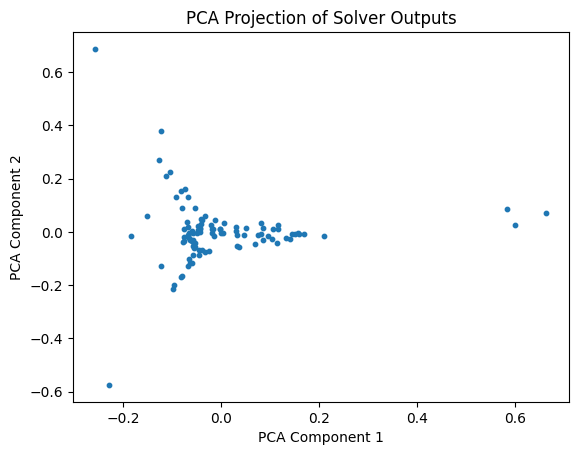

<Figure size 640x480 with 0 Axes>

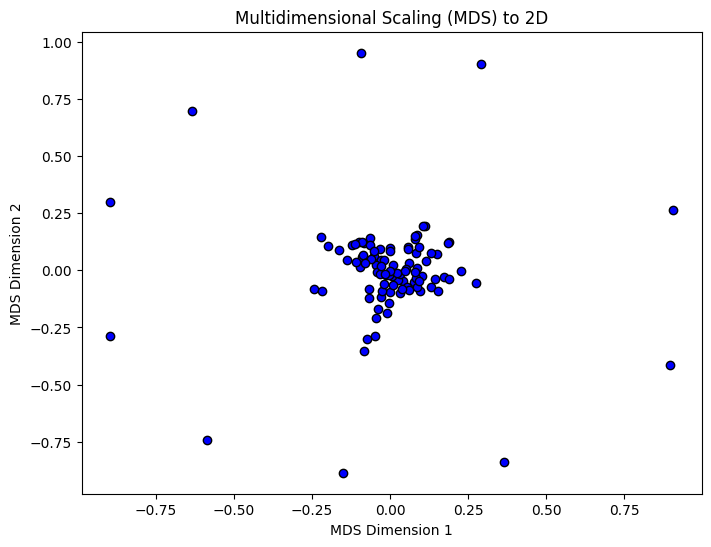

<Figure size 640x480 with 0 Axes>

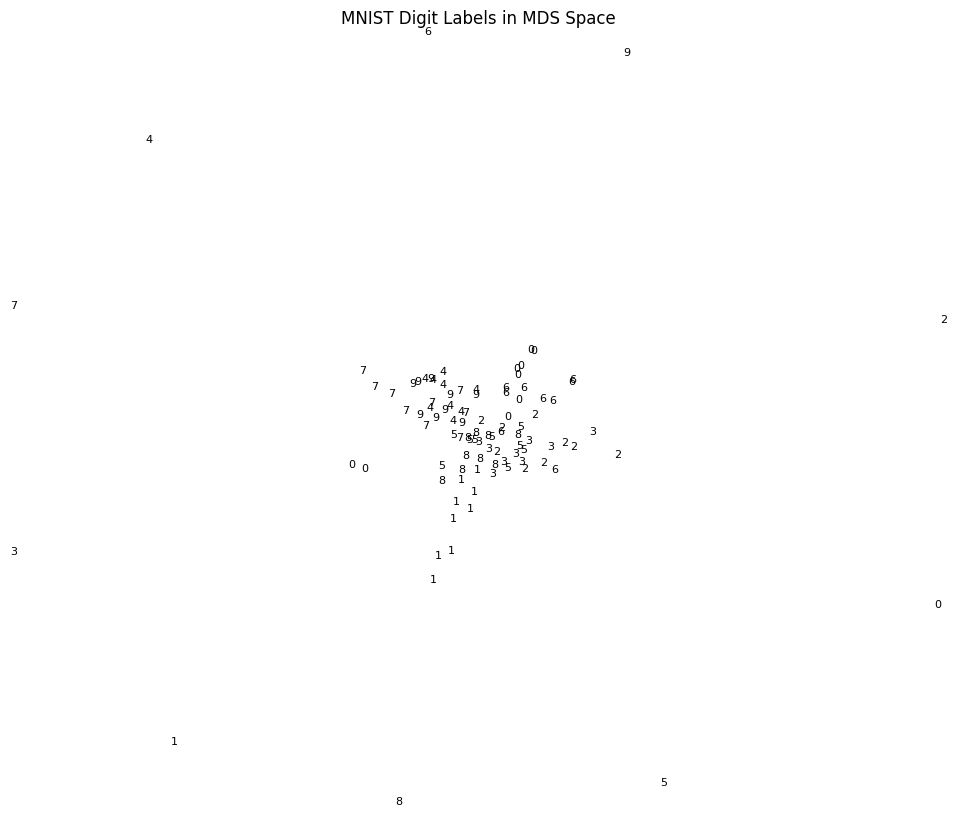

In [165]:
points = np.array(list(map(list, zip(*voltages))))

# print(points.shape)

# PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)

# print(points_2d.shape)

plt.scatter(points_2d[:, 0], points_2d[:, 1], s=10)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Solver Outputs")

plt.show()
# plt.savefig(fileStarter + "_PCA.png")
plt.clf()

# MDS
mds = MDS(n_components=2, random_state=42)
transformed_points = mds.fit_transform(points)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='blue', edgecolors='black')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("Multidimensional Scaling (MDS) to 2D")

# plt.savefig(fileStarter + "_MDS.png")
plt.show()
plt.clf()

fig, ax = plt.subplots(figsize=(12, 10))

for i in range(len(transformed_points)):
    ax.text(transformed_points[i, 0], transformed_points[i, 1], str(correct[i]),
            color='black', fontsize=8, alpha=1,
            ha='center', va='center')

ax.set_xlim(transformed_points[:, 0].min(), transformed_points[:, 0].max())
ax.set_ylim(transformed_points[:, 1].min(), transformed_points[:, 1].max())
plt.axis('off')
plt.title("MNIST Digit Labels in MDS Space")
plt.show()
